# Self-Driving Car Engineer Nanodegree

## Note: This notebook contains the codes and final results only. The explanations and outputs are provided with the README.md file.


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 
import math
import os

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


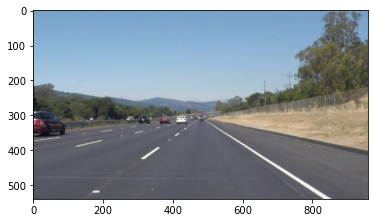

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
# Image Loader and saver Helper. Set a default path for each.
def load_images(path='./test_images'):
    images_list = os.listdir(path)
    return [mpimg.imread(path+'/'+img) for img in images_list]

def load_image_names(path='./test_images'):
    return os.listdir(path)

def show_imgs(imgs, label):
    assert (len(imgs) == len(label))
    num_imgs = len(imgs)
    plt.figure(figsize=(20,10))
    for i in range(num_imgs):
        plt.subplot(int(num_imgs/2), 2, i+1)
        plt.imshow(imgs[i])
        plt.title(label[i])
    plt.show()
    
def save_imgs(imgs, img_labels, path='./test_images_output/'):
    for i in range(len(img_labels)):
        mpimg.imsave(path+img_labels[i], imgs[i])

def save_img(img, img_label, cmap='viridis', path='./test_images_output/'):
    mpimg.imsave(path+img_label, img, cmap=cmap)
        
def show_img(img, img_label, processed_img, processed_img_label):
    plt.figure(figsize=(20,10))
    plt.subplot(121),plt.imshow(img)
    plt.title(img_label)
    plt.subplot(122),plt.imshow(processed_img)
    plt.title(processed_img_label)
    plt.show()

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
# Now the helper routines

# Gaussian smoothing kernel
def gaussian_blur(img, kernel_size=3):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


# RGB to GrayScale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


# RGB to HSV. Doesn't give good contrast. Use HSL instead
def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


# RGB to HLS. Is much better for contrast
def hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)


# Canny Edge Detection
def canny(img, low_threshold=50, high_threshold=150):
    return cv2.Canny(img, low_threshold, high_threshold)


# Filtering based on color. Since yellow is used, we use HLS values for that purpose(60,0.4,0.32) to (60, 0.6, 0.8)
def yellow_mask(img, lower_yellow_threshold=np.array([20,100,100]), higher_yellow_threshold=np.array([40, 255, 255])):
    return cv2.inRange(img, lower_yellow_threshold, higher_yellow_threshold)


# Filtering mask based on white color (HLS)
def white_mask(img, lower_threshold = np.array([0, 200, 0]), upper_threshold = np.array([255, 255, 255])):
    return cv2.inRange(img, lower_threshold, upper_threshold)


# Combining the yellow and white masks with bitwise OR
def combined_color_mask(img):
    hls_img = hls(img)
    mask_yellow = yellow_mask(hls_img)
    mask_white = white_mask(hls_img)
    return cv2.bitwise_or(mask_yellow, mask_white)


# Finding the region of interest based on the Polygonal Area Mask. Image is the masked image
def region_of_interest(masked_image, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(masked_image)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(masked_image.shape) > 2:
        channel_count = masked_image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    return cv2.bitwise_and(masked_image, masked_image, mask = mask)


# Hough Lines
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Weighted Image
def weighted_img(img, initial_img, α=0.7, β=2., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


# Slope calculation from the end points (x1, y1), (x2, y2) of the line segment
def get_slope(x1, y1, x2, y2):
    
    # Check for Infinity
    if (x2-x1) == 0:
        return math.inf
    else:
        return (y2-y1)/(x2-x1)

# Intercepts calculation from slope and (x,y) pair.
def get_intercepts(x, y, slope):
    return y - slope*x

# Draw Lines for segments. For use with visualizing the hough line segments output only.
def draw_line_segments(img, lines, color=[0, 255, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = get_slope(x1, y1, x2, y2)
            if (slope < -0.3 and slope != math.inf):
                cv2.line(img, (x1, y1), (x2, y2), color = [0, 255, 0], thickness=5)
            elif (slope > 0.3 and slope != math.inf):
                cv2.line(img, (x1, y1), (x2, y2), color = [255, 0, 0], thickness=5)

        
# Draw Lines function with linear interpolation
def draw_lines(img, lines, color=[0, 255, 0], thickness=10):
    """
    Linear interpolation of hough lines. Used by default.
    This function does the following:
    1. Separate left and right lanes based on slope. For left line, slope to be less than -slope_thresh, and for right line, slope > slope_thresh
    2. Store the slope and intercepts.
    3. Find the mean slope and intercept.
    4. Extrapolate to the designated points by calculating x1 and x2 correspoinding to y1_global and y2_global (see below)
    
    """
    imshape = img.shape
    
    # The region boundaries for drawing the lane lines as defined by the y coordinates. 
    # We have to find the corresponding x coordinates.
    y1_global = int(imshape[0])
    y2_global = int(0.7*imshape[0])
    
    # Lists to hold the slopes and intercepts for the left and right lanes
    left_slopes = []
    right_slopes = []
    left_intercepts = []
    right_intercepts = []
    
    #Temporary variables for use in calculations.
    slope, intercept = 0, 0
    x1_left, x2_left, x1_right, x2_right = 0, 0, 0, 0
    
    #Avoid parallel lines. Set threshold (hard coded for now)
    slope_thresh = 0.3
    for line in lines:
        for x1, y1, x2, y2 in line:
            
            # Determine the slope
            slope = get_slope(x1, y1, x2, y2)
            
            # Check for threshold requirements and eliminate results with slope=infinity, if any.
            if (slope < -slope_thresh and slope != math.inf):
                left_slopes.append(slope)
                left_intercepts.append(get_intercepts(x1, y1, slope))
            elif (slope > slope_thresh and slope != math.inf):
                right_slopes.append(slope)
                right_intercepts.append(get_intercepts(x1, y1, slope))
                
    # Get the mean values for slopes and intercepts. 
    # Then extract the x coordinates corresponding to y1_global and y2_global for drawing the line to the image boundaries.
    # Formula: x = (y-intercept)/slope.
    
    if (len(left_slopes) != 0):
        mean_left_slope = np.mean(left_slopes)
        mean_left_intercepts = np.mean(left_intercepts)
        x1_left = int((y1_global - mean_left_intercepts)/mean_left_slope)
        x2_left = int((y2_global - mean_left_intercepts)/mean_left_slope)
        cv2.line(img, (x1_left, y1_global), (x2_left, y2_global), color, thickness)
    
    if (len(right_slopes) != 0):
        mean_right_slope = np.mean(right_slopes)
        mean_right_intercept = np.mean(right_intercepts)
        x1_right = int((y1_global - mean_right_intercept)/mean_right_slope)
        x2_right = int((y2_global - mean_right_intercept)/mean_right_slope)
        # Change color for right lane to red for clarity.
        cv2.line(img, (x1_right, y1_global), (x2_right, y2_global), color = [255, 0, 0], thickness=10)
        
# Polynomial_version of draw_lines
def draw_poly(img, lines, color=[0, 255, 0], thickness=5):
    '''
    Polynomial fitting of hough lines to generalize on curved lanes. 
    To use this function, please change the draw_lines() function to draw_poly() in hough_lines() function.
    This function does the following:
    1. Separates the (x,y) point pairs of the line segments into left and right lanes, based on the slope as above.
    2. Store them into the separate arrays.
    3. Fit a 2nd degree polynomial to the (y,x) pairs, ie x = z(y).
    4. Generate a set of points y in [y1_global, y2_global]
    5. Determine the corresponding x from x = z(y)
    6. If max(y) < y1_global, linearly interpolate to the endpoint (hard coded) at (180, y1_global) and (870, y1_global). 
    '''
    imshape = img.shape
    
    # The region boundaries for drawing the lane lines as defined by the y coordinates. 
    # We have to find the corresponding x coordinates.
    y1_global = int(imshape[0])
    y2_global = int(0.7*imshape[0])
    
    
    # Placeholder lists to hold the x an y values for the left and right lanes.
    left_x = []
    right_x = []
    left_y = []
    right_y = []
    
    # Temporary variable for holding slope calculation results
    slope= 0
    
    #Avoid parallel lines. Set threshold
    slope_thresh = 0.3
    for line in lines:
        for x1, y1, x2, y2 in line:
            
            # Determine the slope for the segment
            slope = get_slope(x1, y1, x2, y2)
            
            # Apply thresholding requirements and eliminate results with slope=infinity
            if (slope < -slope_thresh and slope != math.inf):
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
            elif (slope > slope_thresh and slope != math.inf):
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
                
    # Polynomial interpolation and combination with linear interpolation.
    if (len(left_x) != 0):
        
        # Find the maximum Y value (to detect if region boundary has been reached or not)
        left_y_max = int(np.max(left_y))
        
        # Fit a 2nd degree curve to the segment points 
        z1 = np.polyfit(left_y, left_x, 2)
        
        # Generate a set of points to draw the curve
        draw_y = np.arange(left_y_max, y2_global, -1, dtype=np.int32)
        
        # Evaluate the polynomial for the corresponding y values and find the x coordinates
        draw_x = np.polyval(z1, draw_y)
        draw_points = (np.asarray([draw_x, draw_y]).T).astype(np.int32)
        
        # Draw the curve
        cv2.polylines(img, [draw_points], False, color, thickness)
        
        # If region boundary has not been reached, linearly interpolate from (180, y1_global). 
        # Polynomial interpolation did not work well here.
        if left_y_max < y1_global:
            cv2.line(img, (180, y1_global), (int(np.polyval(z1, left_y_max)), left_y_max), color, thickness)
        
    
    if (len(right_x) != 0):
        right_y_max = int(np.max(right_y))
        z2 = np.polyfit(right_y, right_x, 2)
        draw_y2 = np.arange(right_y_max, y2_global, -1, dtype=np.int32)
        draw_x = np.polyval(z2, draw_y2)
        draw_points = (np.asarray([draw_x, draw_y2]).T).astype(np.int32)
        cv2.polylines(img, [draw_points], False, color=[255, 0, 0] , thickness = 5)
        # If region boundary has not been reached, linearly interpolate from (870, y1_global). 
        # Polynomial interpolation did not work well here.
        if right_y_max < y1_global:
            cv2.line(img, (870, y1_global), (int(np.polyval(z2, right_y_max)), right_y_max), color=[255,0,0], thickness=5)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [6]:
# Detection Pipeline
def process_image(image, kernel_size=3, canny_low=70, canny_high=140, rho=1, theta=np.pi/180, 
             threshold=30, min_line_len=1, max_line_gap=50):
    color_mask = combined_color_mask(image)
    gray = grayscale(image)
    grayed_masked = cv2.bitwise_and(gray, gray, mask = color_mask)
    blur = gaussian_blur(grayed_masked, kernel_size)
    canny_edges = canny(blur, canny_low, canny_high)
    vertices = np.array([[100, canny_edges.shape[0]], 
                         [430, 320], 
                         [530, 320], 
                         [canny_edges.shape[1], canny_edges.shape[0]]], np.int32)
    roi = region_of_interest(canny_edges, [vertices])
    h_lines = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)
    final_img = weighted_img(h_lines, image)
    return final_img

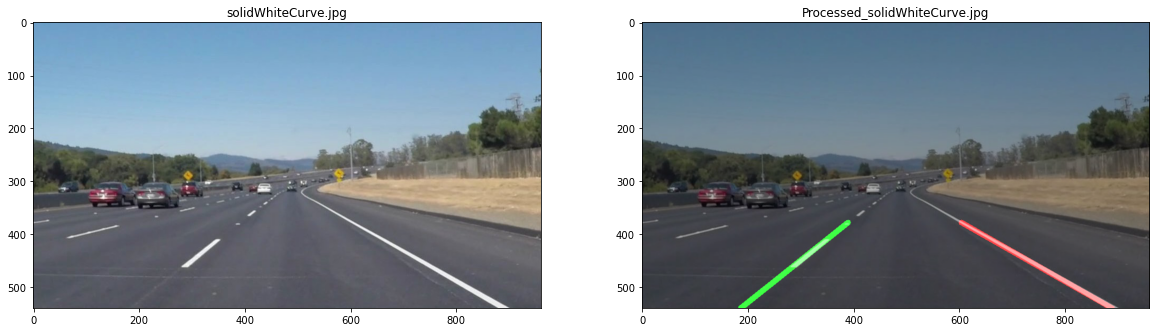

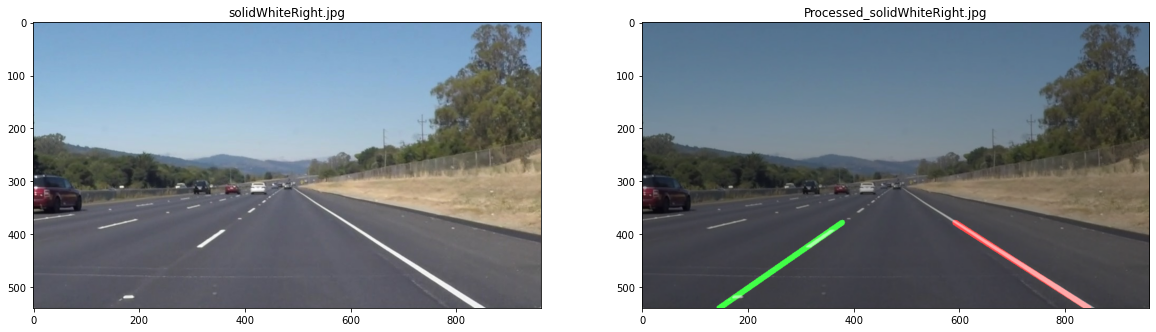

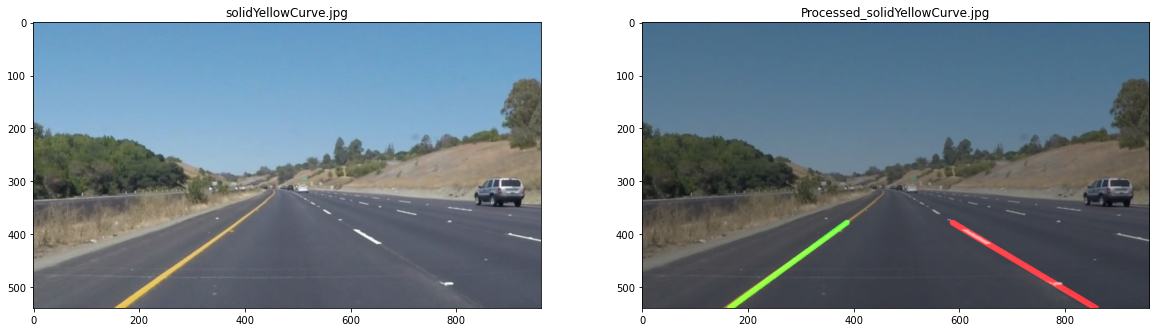

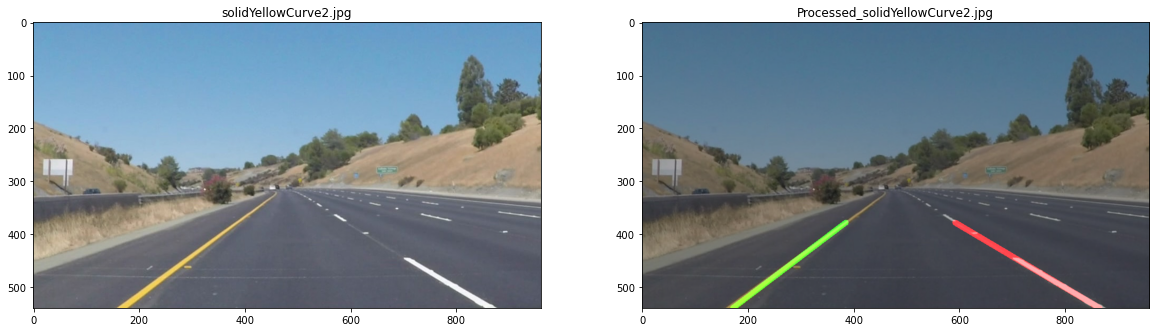

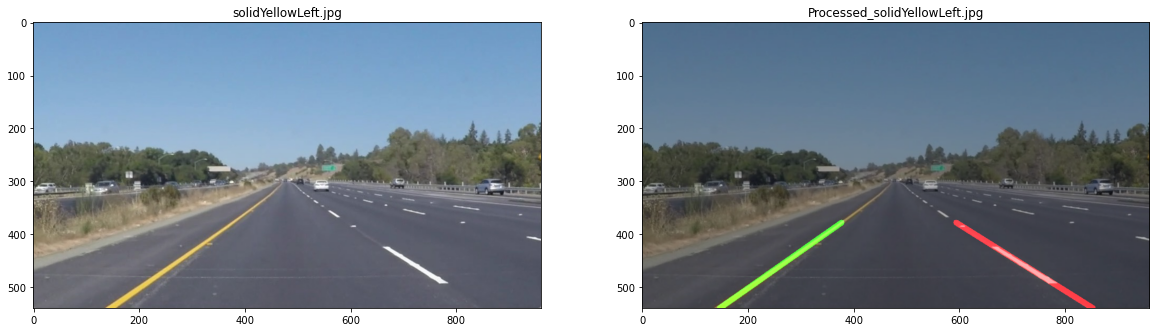

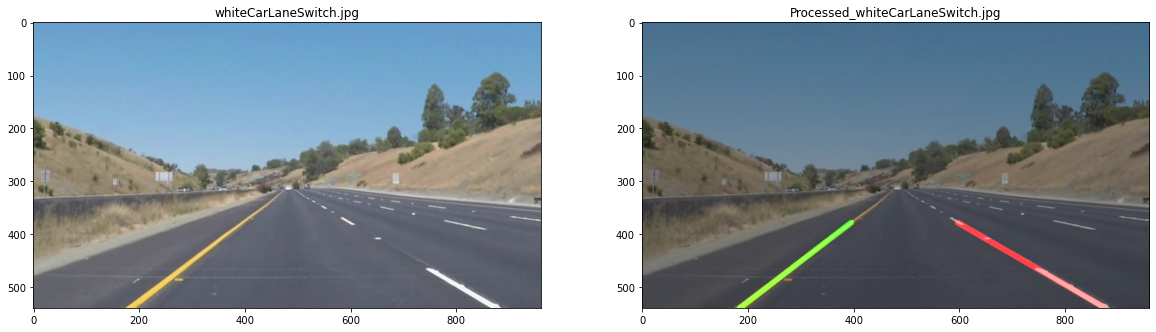

In [7]:
# Let's test the pipeline
a = load_images()
labels = load_image_names()
for i in range(len(a)):
    show_img(a[i], labels[i], process_image(a[i]), 'Processed_'+labels[i])
    save_img(process_image(a[i]), 'Processed_'+labels[i])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   4%|██▍                                                                  | 8/221 [00:00<00:02, 77.42it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 2.58 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▊                                                                    | 8/681 [00:00<00:09, 71.10it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 6.86 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|█▎                                                                   | 5/251 [00:00<00:05, 45.60it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 4.62 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))